# **MDX 데이터 분석하기**
https://pypi.org/project/mdict-utils/
1. **MDX 사전파일을** 활용하여 객체에 구분하기
1. 각 사전의 첫번째 의미를 통해서 **NER** 사전 만들기
1. 추후에 보완을 해서 wordnet 으로 강화하기

## **1 데이터 불러오기**
작업한 내용을 대상으로 중분류 내용 추가하기
- 법률, 식품, 자동차 등 중분류 내용이 당장은 필요가 없어 보인다.
- 작업을 진행하면서 필요하면 추가하기

In [2]:
import pickle
with open('data/nerDict.pk', 'rb') as handle:
    nerDict = pickle.load(handle)
nerDict.shape

(388091, 2)

In [3]:
query     = "너비아니"  # 원문 내용의 확인
q_data    = nerDict[nerDict.Text == query].Data.values.tolist()
q_data[0]

[('명사',
  ['명사',
   '얄팍하게 저며 갖은 양념을 하여 구운 쇠고기.',
   '¶ 석쇠에 너비아니를 구우니 연기가 올라왔다./송 씨는 새로 구워 온 너비아니 접시를 상 위에 올려놓으며, 신호의 눈치를 살폈다.≪최일남, 거룩한 응달≫\r\n'])]

In [4]:
food_token = ["식용","양념","음식","물고기","고기","동물","야채","열매","잎","줄기","생선"]

from muyong.nlp import skdict_filter
from konlpy.tag import Okt
skdict_filter(Okt(), nerDict, food_token, "식빵")

'식빵'

## **2 N-Gram 데이터**
**itemIndexTemp** 를 활용하며 고유단어 찾기

In [8]:
import pandas as pd
menus = pd.read_csv('data/menu_muyong.csv', encoding='ms949')
menus = menus.dropna(subset=['메인1', '메인2'])
menus = menus.fillna('')  # NaN 값을 지운다
menus.head(2)

,년도,주차,요일,구분,메인1,메인2,메인3,메인4,메인5,메인6,메인7,메인8,메인9,메인10,Unnamed: 14
1,2017,52,화,중식,황태미역국,매콤제육볶음,해물볶음우동,팽이맛살계란전,양상추샐러드,흑임자D,치커리사과겉절이,양념깻잎지,포기김치,,
2,2017,52,수,중식,육개장,사천식칠리탕수육,카레라이스,멸치꽈리볶음,사과단감샐러드,훈제오리야채겨자무침,콩나물매콤무침,포기김치,,,


In [9]:
# DataFrame 에서 고유 Token List 추출
tokens, result = [], []
for _ in menus.columns[4:]:
    tokens += menus[_].values.tolist()

# &, %, ., / 등의 제거 후, 고유 Token 문서 만들기 
import re
for _ in tokens:
    _temp = re.findall(r"\w+", _)
    if _temp:  result += _temp
tokens = list(set(result))
print(len(tokens)), " ".join(tokens[:25])

2903


(None,
 '매콤너비아니떡갈비 돈육탕수 상하이치킨스파게티 누룽지만두탕수 꼬미김말이튀김 직화산적매콤볶음 매운등뼈찜 참깨D 맥시칸샐러드 돈장조림 고추지 매콤장어맛꽁치구이 김치옥수수전 비엔나브로콜리칠리볶음 소라살참나물무침 가자미조림 돈뮥보쌈 꽃게미더덕해물탕 미트볼피자소스조림 달래양념장 쭈꾸미떡매콤볶음 배추전 얼큰함동태찌개 실곤약샐러드 짜장볶음우동')

In [10]:
# Okt 모듈로 명사만 찾기 (대중적 선별기준)
from konlpy.tag import Okt
token_Okt = Okt().morphs(" ".join(tokens))
len(tokens), len(token_Okt)

(2903, 8965)

In [11]:
# N-Gram 유용한 값 찾기
n_gram, tokeNgram = 4, []
def ngram(token, n):
    return [token[_: _+n] for _ in range(0, (len(token)-n+1))]

for _ in tokens:
    tokeNgram += ngram(_, n_gram)

from nltk import Text
ngramObj = Text(tokeNgram)   # [list] 객체로 Text 객체의 생성

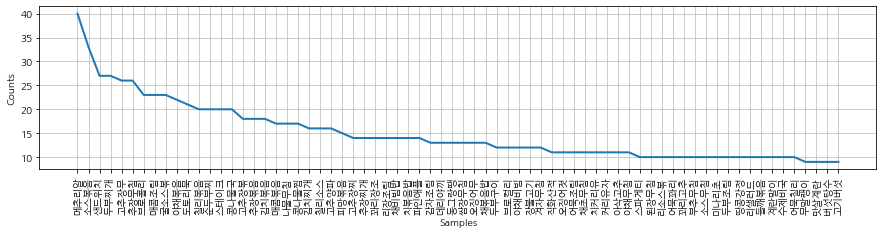

In [12]:
%matplotlib inline
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
rc('font', family=['NanumGothic','Malgun Gothic']) # 한글의 표시
rcParams['axes.unicode_minus'] = False             # '-' 표시의 처리
plt.figure(figsize=(15, 3))  # 파레트 설정
ngramObj.plot(70)

## **3 N-Gram 의 Filtering**
**itemIndexTemp** 를 활용하며 고유단어 찾기
1. **Naver API 검색결과** 를 활용하는 등의 응용 방법도 가능하다

In [14]:
# N-Gram 단어들 중 사전에 있는 단어로 필터링
itemIndex     = nerDict.Text.values.tolist()
itemIndexTemp = list(set(itemIndex))
len(itemIndexTemp), len(itemIndex)

(320585, 388091)

In [15]:
# itemIndexTemp : NER 객체어 사전으로 필터링
valid_token = []
unvalid_token = []
voca_tokens = ngramObj.vocab().most_common()

from tqdm import tqdm
for _ in tqdm(voca_tokens):
    if _[0] in itemIndexTemp: 
        valid_token.append(_[0])
    else: 
        unvalid_token.append(_[0])

# 유효하게 추출된 단어는 96개
len(valid_token), len(unvalid_token)

100%|██████████| 5554/5554 [01:37<00:00, 57.23it/s]


(96, 5458)

## **4 N-Gram 데이터**
**itemIndexTemp** 를 활용하며 고유단어 찾기

In [16]:
# 원본 메뉴데이터 새로 불러오기
for _ in menus.columns[4:]:
    tokens += menus[_].values.tolist()
len(tokens) # 메뉴 Tokens

28764

In [ ]:
# K-Big 수집결과 30만개 중 11만개의 식품 연관단어 추출
with open('data/nouns01_std.txt', 'r') as f:
    token_nouns = f.read()
food_unique_tokens = sorted(set(token_nouns.split(',')))
valid_token, unvalid_token = [], []

# unigram ~ 7gram 까지 유효성 사전검사 반복실행
from muyong.nlp import ngram_to_Text
for _n in range(1,7):  
    ngramObj    = ngram_to_Text(tokens, n_gram=_n)
    voca_tokens = ngramObj.vocab().most_common()
    for _ in voca_tokens:
        # food_unique_tokens : NER 객체어 사전
        if _[0] in food_unique_tokens: 
            valid_token.append(_[0])
        else: 
            unvalid_token.append(_[0])
    print("{:2} n_gram  valid Tokens: {:4,}  unvalid: {:6,}".format(
        _n, len(valid_token), len(unvalid_token)))

In [ ]:
# 작업결과를 바탕으로 Huristic 내용의 수정/ 보완하기
plus_word   = """등갈비/가자미/구이/조림/탕/튀김/채/깻잎/쭈꾸미/소갈비/소세지/자반/오징어/햄/호박/범벅/호박범벅/
/홍어/후랑크/고추장/열무/나물/매운/등뼈/찜/꽁치/스프/후르츠/매콤/새송이/콘/닭/곤약/굴소스/버터/치킨/스파게티/피망/
/브로컬리/브로컬리/계란/맛살/치즈/꼬치/데리야끼/장국/견과류/장조림/얼큰/콩나물/팽이/팽이버섯/칠리/칠리소스/우동/
/미트볼/강정/고로게/고로케/메추리알/날치알/탕수강정/마카로니/사골/황태/까르보나라/돈육/깐풍육/깐풍기/해물/짜장/
/해파리/냉채/실치/순살/파/파채/참치/비엔나/조개/해장국/야채/게맛살/들깨소스/감귤/무말랭이/소보로/새우젓//조갯살/노각/
/생채/산채나물/파스타/치커리/숙주/돈/우거지/숙주나물/에그/연근/파인/얼갈이/장어/단무지/주먹밥/된장/동태/문어/깨/돈나물/
/진미채/오징어젓/된장국/미소/미소국/도토리묵/가쓰오국/누룽지/소스/깐풍/바베큐소스/카레/북어/코다리/묵은지/알배기/산채/
/케찹/케첩/느타리버섯/김치/볶음밥/감자/튀김/겉절이/해초/까스/찜닭/지리/새싹/겉절이/함박/뼈다귀/탕수/소면/베이컨/고구마순/
/말이/카레/라이스/청포묵/까스/돈까스/타코야끼/너바이니/반계탕/후르츠/칵테일/야채/샐러드/애호박/쥐어/가오리/천사채/새콤/
/우렁/베이컨/닭꼬치/유린기/돈까스/돈가스/홍합/오뎅/소면/들깨/소스/영양탕/찐빵/동그랑땡/김말이/크래미/춘장/대구/구이/사천/
/군만두/유린기/애호박/후라이드/뼈다귀/명엽채/청포북/양장피/묵/무침/짬봉/소면/경단/마요네즈/뼈다귀/깻순/꺳잎/깻잎/해초/고추/
/데미소스/순두부/찌개/찜닭/곤드레(풀)/모밀/메밀/빈대떡/떡볶이/어묵무침/흑임자/굴/쌀/동그랑땡/가쯔오/마요/곰피/푸실리/초무침/
/동그랑땡/스팸/천사채/마요/고등어/후루츠/와사비/찹쌀/아몬드/명태/메추리/계장/민찌/새싹/석박지/무석박지/쭈꾸미/포테이토/""" 
# 추가할 내용을 Huristic 선별 후 추가
except_word = """고사/기/꾸미/다대/다리/대/대국/동/두/등/띠/미파/물파/물새우/물배추/미무/바라기/박/박새/발/부들/
/부어/부육/부초/산/살/살파/상/선/소갈/수/어미/어부/어비/어자반/어조/어채/어초/어해/오어/우마/우무/운감/조/종/주식/
/줄/지간/지감/지어/진/집/쪽/키/파리/파초/팽/포/풍/피/합/햄에그/호박범벅/홍어회/각/갓무/견과/과류/물국/약/육/순살/순살/
/개/색소/각부/육장/인/이초/모/진미/고추장찌개/양초/육보/젓/살치/겨자무/김치볶음밥/소/카레라이스/싹/순/야채샐러드/들깨소스/
/귀/그릇/대구구이/맥/이드/귀/묵무침/경/고추전/순두부찌개/거/감자튀김/장지/""" # 국내산, 중국산 내용 제거
except_word = except_word.split('/')
valid_token = [_ for _ in valid_token if _ not in except_word]
valid_token += plus_word.split('/')
valid_token = sorted(list(set(valid_token))); print(len(valid_token))

# 현재 작업된 결과가 있는만큼 추가하지 않기
# with open("data/nouns03_food.txt", "w") as f:
#     f.write(",".join(valid_token[2:]))
",".join(valid_token)[:300] # ",".join(valid_token[2:100])

In [ ]:
import re
from nltk import Text
token_list = re.findall(r"[가-힣]+", " ".join(tokens))
token_list = list(set(token_list))
len(token_list), " ".join(token_list[:10])

In [ ]:
from collections import defaultdict
def food_unique_tokens(token_temp, valid_token):
    token_temp_list = defaultdict(int)
    for _ in valid_token:      # 검증용 단어와 일치여부 확인
        if token_temp.find(_) != -1: # 포함된 Token 추출
            token_temp_list[_] = len(_)

    # 검증용 단어 중, 중복token 필터링 (길이가 긴 단어순 정렬 후 중복단어들 제거하기)
    token_temp_list = sorted(token_temp_list.items(), key = lambda i: i[1], reverse=True)
    token_temp_list = [_[0]  for _ in token_temp_list]
    for i, _ in enumerate(token_temp_list):
        for chk in token_temp_list[i+1:]:
            if _.find(chk) != -1:
                token_temp_list.remove(chk)
                
    # 개별 단어의 출현순서(find)로 재정렬 {token:index}
    token_rerange = {_:token_temp.find(_)  for _ in token_temp_list}
    token_rerange = list(sorted(token_rerange.items(), key = lambda i: i[1], reverse=False))
    token_temp_list = [_[0]  for _ in token_rerange]
    return token_temp_list

In [ ]:
# Valid Unique Token
token_temp   = token_list[1428]
print("원본내용:", token_temp)
token_filter = food_unique_tokens(token_temp, valid_token)
token_filter

## **5 내용의 분류 수정**
음식의 Type 에 따라 사전을 다르게 적용하기
1. **Category 를 구분** 하는 사전
1. 구분한 결과로 **식별용 개별 단어사전** 작업하기

In [ ]:
token01 = """,랍스타,로스트,수제쿠키,쉐이크,쉬림프,스낵,스크램블,멜론,버거,버팔로윙,쏘세지,아이스크림,애플,더치커피,
,도넛,또띠아,또띠야,라떼,롤케이크,리조또,마들렌,마멀레이드,마카롱,스트로베리,시나몬,요거트,요구르트,머랭쿠키,머핀,모카,
,모카머핀,바닐라,바질,발사믹,생크림,브리또,비스킷,빙수,올리브,올리브오일,와인,와플,우유,자몽,젤리,주스,쥬스,진저,쨈,
,시리얼,체리,초코머핀,초코볼,초코칩,초코칩머핀,초코쿠키,초콜릿,초콜릿칩,츄러스,카라멜,카스테라,카페모카,캐러멜,캬라멜,
,커피,컵케이크,컵케익,케이크,케익,케일,코코넛,코코아,쿠키,크래커,크랜베리,크레페,크로와상,크리미,크림,크림머핀,타르타르,
,타르트,토스트,티라미수,티라미슈,파운드케이크,푀유나베,푸딩,프레첼,프렌치,프렌치토스트,핫케이크,핫케익,허브,타코,낫토,
,모카,발사믹,브리또,스트로베리,요거트,초코칩,컵케이크,케일,타코,파운드케이크,핫케이크,

,가슴살,계란,고구마줄기,고등어,고명,고추,고춧가루,과메기,광어,구이,구절판,군밤,깍뚜기,꼬막,꼴뚜기,나물,나박,해삼,냉국,냉라면,
,노가리,다슬기,달걀,달래,닭도리탕,대추,동치미,두부,두유,들기름,라떼,라면,라볶이,막걸리,식혜,탕수,참외,말랭이,목살,묵사발,
,미숫가루,민어,병어,볶음,부추,부침,부침개,말랭이,목살,묵사발,미숫가루,민어,병어,볶음,부추,부침,부침개,막걸리,맥주,메기,멘보샤,
,명란,명란젓,모과,밤,뱅어포,복분자,붕어,삼겹,새우,샐러리,생강,샤브샤브,석류,소바,소박이,송어,수프,식혜,아구,에이드,오골계,
,오믈렛,오향장육,옥수동,우럭,우육면,육우,잼쿠키,전골,젓갈,제육,조림,족발,주꾸미,쥐포,참기름,참외,탕수,토란대,튀각,튀김,한라봉,
,한치,호두,홍삼,홍시,황도,후라이,흑임자,"""

In [ ]:
# 명사 추출사전 데이터 호출
# with open("data/nouns_food_03-2.txt", "r") as f:
#     valid_token = f.read()
# valid_token = valid_token.split(","); len(valid_token)
# except_word = """/""" # 국내산, 중국산 내용 제거
# valid_token += plus_word.split('/')
# # valid_token = [_ for _ in valid_token if _ not in except_word.split('/')]
# valid_token = sorted(list(set(valid_token)))
# valid_token += valid_token[0].split(",")
# valid_token =  sorted(set(valid_token[1:]))[3:]
# with open("data/nouns_food_03-2.txt", "w") as f:
#     f.write(",".join(valid_token))
# len(valid_token)

In [ ]:
# 1# 1# korea       = []  # 1.한식분류
west        = []  # 2.서양식
chijap      = []  # 3.중식일식
fruitSource = []  # 4.과일소스
desert      = []  # 5.디저트
error       = []

for no, _ in enumerate(token01.split(",")):
    x = input(_ + "\n(1)한,(2)서양,(3)중일,(4)과일소스,(5)디저트")
    if int(x) == 1: 
        korea.append(_)
        print("{:.2f}% 한식 분류완료 : ".format( no/len(token01.split(",")) * 100))
    elif int(x) == 2:
        west.append(_)
        print(">> 양식 분류완료")
    elif int(x) == 3:
        west.append(_)
        print(">> 중일식 분류 완료")
    elif int(x) == 4:
        west.append(_)
        print(">> 과일소스 분류 완료")
    elif int(x) == 5:
        west.append(_)
        print(">> 디저트 분류 완료")
    else:
        print(">>>> ERROR >>>> 입력 내용이 없습니다 >>>>")
        error.append()
error

# **NLP 기본 함수들**
레빈스타인 편집함수등 기본적인 내용 정리하기

## **1 Python 기본함수로 만들기**
from Tutorials

In [ ]:
def levenshtein(s, t, display=False):
    """ iterative_levenshtein(s, t) -> ldist
    ldist is the Levenshtein distance between the strings s and t.
    For all i and j, dist[i,j] will contain the Levenshtein distance 
    between the first i characters of s and the first j characters of t"""
    rows, cols = len(s)+1, len(t)+1
    dist = [[0 for x in range(cols)] for x in range(rows)]
    # source prefixes can be transformed into empty strings 
    # by deletions:
    for i in range(1, rows):
        dist[i][0] = i
    # target prefixes can be created from an empty source string
    # by inserting the characters
    for i in range(1, cols):
        dist[0][i] = i     
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]: cost = 0
            else: cost = 1
            dist[row][col] = min(dist[row-1][col] + 1,      # deletion
                                 dist[row][col-1] + 1,      # insertion
                                 dist[row-1][col-1] + cost) # substitution
    for r in range(rows):
        if display: print(dist[r]) # 중간과정의 출력 
    return dist[row][col]

print(levenshtein("아이오아이", "아이오아이"))

In [ ]:
import numpy as np
def levenshtein_ratio(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

In [ ]:
s1 = '아이디어'
s2 = '어디아이'
levenshtein_ratio(s1, s2, ratio_calc=True)

## **2 Soynlp 모듈의 응용**
기본원리와 함께, 한글용 응용모듈로써 가장 자료가 많다

In [ ]:
from soynlp.hangle import levenshtein
from soynlp.hangle import jamo_levenshtein

s1 = '아이쿠야'
s2 = '아이쿵야'

print(levenshtein(s1, s2)) # 1
print(jamo_levenshtein(s1, s2)) # 0.3333333333333333

In [ ]:
from soynlp.hangle import compose
from soynlp.hangle import decompose

decompose('꼭') # ('ㄲ', 'ㅗ', 'ㄱ')